# Example Use of tz_world files

    author: Barron H. Henderson
    date: 2020-11-18

## Overview

Use time zone file to create local standard time hour. Then mask (remove) hours outside of an analysis window. Then, perform an analysis (here simple mean).

# All paths are relative to this path

In [1]:
!which python

/usr/local/apps/anaconda/2019.07/anaconda3/bin/python


# Import Libraries

* `os` helps check file existence
* `numpy` helps perform numeric calculations
* `matplotlib` helps create plots
* `PseudoNetCDF` to open IOAPI files

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PseudoNetCDF as pnc

# Define input paths

In [3]:
cpath = 'testo3.nc' # ozone at 1ppb resolved concentrations
tzpath = '../ioapi/tz_world_hours_HEMIS.IOAPI.nc'

# Create a small example input

* if it exists, this step will be skiped.
* if not grab ozone as ppb at 1ppb resolutions (good compression)
* save

In [4]:
if not os.path.exists(cpath):
    rpath = '/work/ROMO/global/CMAQv5.2.1/2016fe_hemi_cb6_16jh/108km/basecase/output/ACONC/CCTM_ACONC_v521_intel17.0_HEMIS_cb6_20160715'
    cf = pnc.pncopen(rpath, format='ioapi').subset(['O3']).eval('O3 = O3 * 1000 // 1; O3.units = "ppb"')
    cf.save(cpath, complevel=1, verbose=0).close()

# Open Timezone and Concentration Inputs

* open both files
* plot the UTCOFFSET (hours from UTC)

In [5]:
tzf = pnc.pncopen(tzpath, format='ioapi').copy()
cf = pnc.pncopen(cpath, format='ioapi').copy()

**PNC:/work/ROMO/anaconda_envs/basic38/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  Currently not using:straight_vertical_longitude_from_pole -98.0


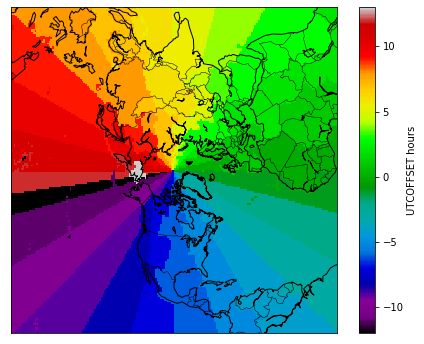

In [6]:
plt.figure(figsize=(8, 6))
ax = tzf.plot('UTCOFFSET', plot_kw=dict(cmap='nipy_spectral'))

# Create LST hour of day

* get times and grab the hour of day
* add the UTC offset (e.g., -5 for Eastern Standard Time)

In [7]:
hours = np.array([t.hour for t in cf.getTimes()], dtype='f')
lsthours = (hours[:, None, None, None] + tzf.variables['UTCOFFSET'][:]) % 24

# Add to output file

* add LSTHOUR as a variable to the file
* this is really just for quick checking

In [8]:
dims = tzf.variables['UTCOFFSET'].dimensions
tvar = cf.copyVariable(lsthours, key='LSTHOUR', dimensions=dims)
tvar.long_name = 'LSTHOUR'
tvar.var_desc = 'LSTHOUR'
tvar.units = 'hour'

# Create Two Means from Two LST Analysis Windows

* midday: 11-15 LST
* night: 0-6LST

In [9]:
middayf = cf.mask(where=~((tvar > 10) & (tvar < 16)), dims=dims).apply(TSTEP='mean')
nightf = cf.mask(where=~((tvar >= 0) & (tvar <= 6)), dims=dims).apply(TSTEP='mean')

# Visualize Results

* LSTHOUR on left, ozone on right
* Midday on top, nigh on bottom

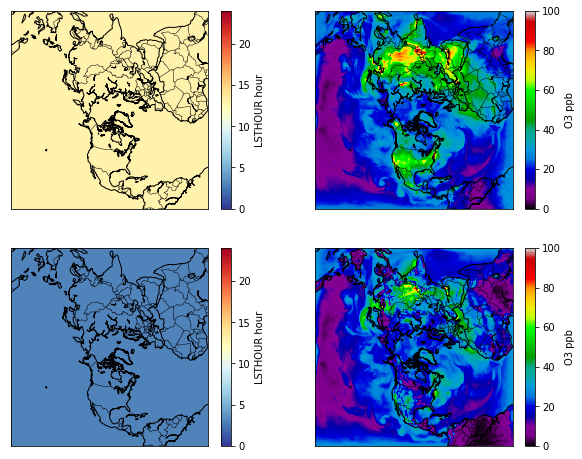

In [10]:
fig, axx = plt.subplots(2, 2, figsize=(10, 8))
plt.sca(axx[0, 0])
middayf.plot('LSTHOUR', plot_kw=dict(vmin=0, vmax=24, cmap='RdYlBu_r'))
plt.sca(axx[0, 1])
middayf.plot('O3', plot_kw=dict(vmin=0, vmax=100, cmap='nipy_spectral'))
plt.sca(axx[1, 0])
nightf.plot('LSTHOUR', plot_kw=dict(vmin=0, vmax=24, cmap='RdYlBu_r'))
plt.sca(axx[1, 1])
nightf.plot('O3', plot_kw=dict(vmin=0, vmax=100, cmap='nipy_spectral'));

# Save Result to Disk

* Optional for example

In [11]:
middayf.save('midday_example.nc', complevel=1, verbose=0).close()

# Similar for met data

* using Ground-level ShortWave radiation
* Shoud maximize at LST noon
* Show UTCOFFSET
* Show max GSW

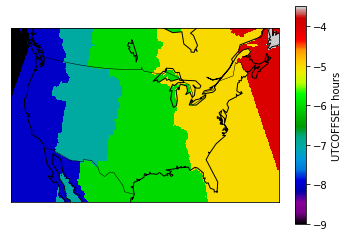

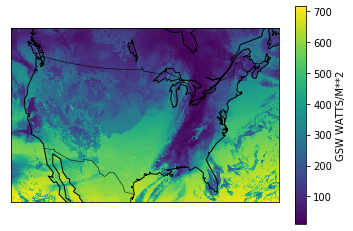

In [12]:
tzpath = '../ioapi/tz_world_hours_12US1.IOAPI.nc'
tzf = pnc.pncopen(tzpath, format='ioapi')
m2f = pnc.pncopen('/home/bhenders/TestData/MCIP/METCRO2D_20110101', format='ioapi').subset(['GSW'])
tzf.plot('UTCOFFSET', plot_kw=dict(cmap='nipy_spectral'))
plt.figure()
m2f.apply(TSTEP='max').plot('GSW')

# Now Visualize Radiation by Hour

* Get fractional LST hour
* Round to even hours
* Mask all hours that are not this hour and plot.
* Notice two types of variation
  * There is a weather system on the East
  * Radiation varies within timezones, which makes sense. Within each timezone, the solar hour is later than the standard hour.

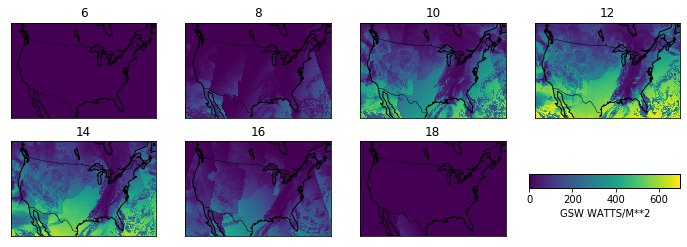

In [13]:
utchour = np.array([t.hour for t in m2f.getTimes()])
lsthour = ((utchour[:, None, None, None] + tzf.variables['UTCOFFSET'][:]) % 24)
# Newfoundland has a fractional timezone. Here we round
lsthour = lsthour.round(0)
dims = tzf.variables['UTCOFFSET'].dimensions
fig, axx = plt.subplots(2, 4, figsize=(12, 4))
cax = axx.ravel()[-1]
for ai, hour in enumerate(range(6, 20, 2)):
    ax = axx.ravel()[ai]
    plt.sca(ax)
    m2f.mask(where=~(lsthour==hour)).apply(TSTEP='mean').plot('GSW', plot_kw=dict(vmin=0, vmax=700), cbar_kw=dict(cax=cax, orientation='horizontal'))
    ax.set_title(str(hour))

cax.set_position([.725, .3, .175, .05])

# LST versus solar time

* 